1. Enable data augmentation, and precompute=True
2. Use lr_find() to find highest learning rate where loss is still clearly improving
3. Train last layer from precomputed activations for 1-2 epochs
4. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
5. Unfreeze all layers
6. Set earlier layers to 3x-10x lower learning rate than next higher layer
7. Use lr_find() again
8. Train full network with cycle_mult=2 until over-fitting


# Pre-requistes

In [1]:
!date

Sun Feb  4 01:27:22 EST 2018


In [2]:
project_name='plant-seedlings-classification'

In [3]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import os, sys

In [5]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [6]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import os
from planet import *

In [7]:
PATH = "/home/paperspace/data/seeds/"
#PATH = "/Users/vinod/programming/DL/data/seedlings/"
assert os.path.exists(PATH)

## Get data

### Directory based structure

In [ ]:
!ls {PATH}

In [ ]:
notebook_dir = os.getcwd()
notebook_dir

In [ ]:
os.chdir(PATH)

In [ ]:
! pwd

In [ ]:
dir_list = os.listdir('train/')
dir_list.remove('.DS_Store')
dir_list

In [ ]:
from random import sample

for dir in dir_list:
    print(dir)
    #files = np.random.permutation(os.listdir(f'train/{dir}'))
    files = os.listdir(f'train/{dir}')
    no_of_valid_files = round(len(files) / 10) # 10%
    print(no_of_valid_files)
    random_files = sample(files, no_of_valid_files)
    print(random_files[:3])
    for file in random_files:
        os.renames(f'{PATH}/train/{dir}/{file}', f'valid/{dir}/{file}') 
    os.listdir(f'{PATH}valid/{dir}/')

In [ ]:
!ls {PATH}valid

In [ ]:
# MAX size
files = !ls -S {PATH}valid/Maize | head
files

In [ ]:
img = plt.imread(f'{PATH}valid/Maize/{files[0]}')
plt.imshow(img)

In [ ]:
# Image data (pixel_col, pixel_row, RGB)
img.shape 

In [ ]:
# MIN size
files = !ls -rS {PATH}valid/Maize | head
files

In [ ]:
img = plt.imread(f'{PATH}valid/Maize/{files[0]}')
plt.imshow(img)

In [ ]:
# Image data (pixel_col, pixel_row, RGB)
img.shape 

In [ ]:
os.chdir(notebook_dir)

In [8]:
def get_tfms(f_model, size): return tfms_from_model(f_model, size)

In [9]:
def get_aug_tfms(f_model, size): return tfms_from_model(f_model, size, aug_tfms=transforms_side_on, max_zoom=1.1)

In [10]:
def get_data_from_csv(f_model, sz, tfms):
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [11]:
def get_data_from_dir(f_mode, sz, tfms, **kwargs):
    return ImageClassifierData.from_paths(PATH, bs, tfms=tfms_from_model(arch, sz), test_name='test')

# Enable data augmentation, and precompute=True

## Initial model setup

In [14]:
arch=resnet34
size=60
bs=64 # default
#metrics=[f2]

In [23]:
data = get_data_from_dir(arch, size, get_aug_tfms(arch, size))

In [24]:
learn = ConvLearner.pretrained(arch, data)

# Use lr_find() to find highest learning rate where loss is still clearly improving

In [25]:
discovered_learning_rate = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 93%|█████████▎| 62/67 [00:06<00:00,  9.28it/s, loss=23.8]


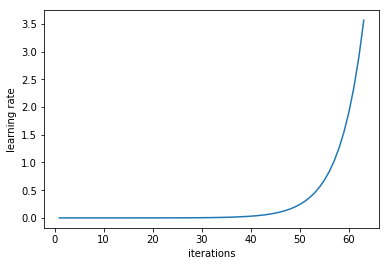

In [26]:
learn.sched.plot_lr()

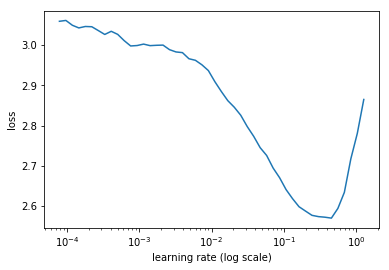

In [27]:
learn.sched.plot()

# Train last layer from precomputed activations for 1-2 epochs

In [28]:
#learning_rate = 0.15 - best results thus far with 60/150/300
learning_rate = 0.1
learning_rates = [learning_rate/9, learning_rate/3, learning_rate]

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      2.1383     1.446999   0.513021  
    1      1.78647    1.369761   0.546007                 
    2      1.40063    1.236089   0.570891                 
    3      1.338811   1.269631   0.548177                 
    4      1.215982   1.179049   0.599175                 
    5      1.089245   1.120227   0.607494                 
    6      0.971375   1.111005   0.607494                  

CPU times: user 5min 15s, sys: 14.3 s, total: 5min 29s
Wall time: 59.1 s


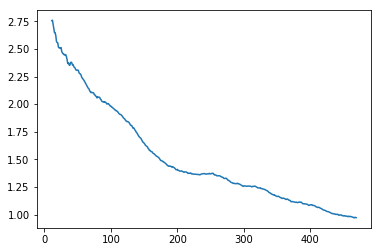

In [29]:
%time learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_last_layer_{size}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.142674   0.741977   0.754196  
    1      0.81442    1.058628   0.657769                  
    2      0.522307   0.479462   0.824508                  
    3      0.501766   0.860524   0.758825                  
    4      0.387758   0.452709   0.861328                  
    5      0.220669   0.417684   0.862558                  
    6      0.14445    0.397072   0.87623                   

CPU times: user 5min 46s, sys: 26.4 s, total: 6min 12s
Wall time: 1min 38s


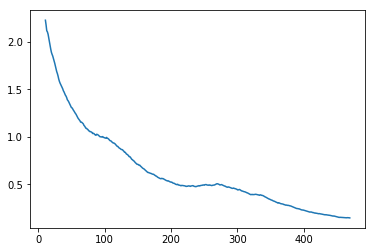

In [30]:
learn.unfreeze()

%time learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_entire_network_{size}')

In [31]:
size = 120
learn.set_data(get_data_from_dir(arch, size, get_aug_tfms(arch, size)))

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.826054   0.688988   0.76888   
    1      0.703592   0.606053   0.814236                  
    2      0.605243   0.577311   0.825955                  
    3      0.612996   0.567093   0.824725                  
    4      0.579114   0.533767   0.83572                   
    5      0.538135   0.51491    0.846933                  
    6      0.50604    0.504275   0.852792                  

CPU times: user 5min 43s, sys: 21.3 s, total: 6min 5s
Wall time: 1min 24s


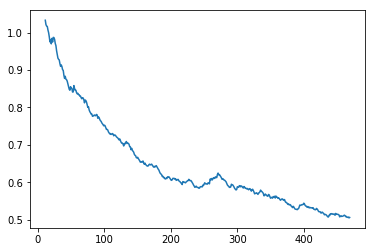

In [32]:
learn.freeze()
%time learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_last_layer_{size}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.560329   0.37682    0.873553  
    1      0.419561   0.320179   0.884549                  
    2      0.249989   0.228475   0.925058                  
    3      0.262152   0.537072   0.835938                  
    4      0.199294   0.233103   0.927734                  
    5      0.113671   0.194432   0.929688                  
    6      0.066172   0.181478   0.941406                   

CPU times: user 7min 4s, sys: 50.6 s, total: 7min 55s
Wall time: 3min 4s


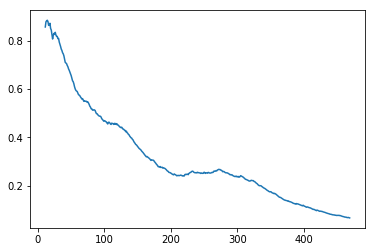

In [33]:
learn.unfreeze()

%time learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_entire_network_{size}')

In [34]:
size = 250
learn.set_data(get_data_from_dir(arch, size, get_aug_tfms(arch, size)))

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.400273   0.296334   0.904297  
    1      0.321597   0.242068   0.929688                  
    2      0.268201   0.228905   0.927734                  
    3      0.276382   0.234505   0.916016                  
    4      0.253315   0.24234    0.908203                  
    5      0.220627   0.22599    0.931641                  
    6      0.202958   0.211247   0.929688                  

CPU times: user 8min 39s, sys: 1min 34s, total: 10min 13s
Wall time: 4min 15s


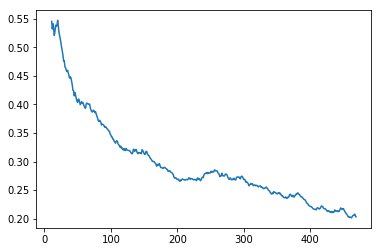

In [35]:
learn.freeze()
%time learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_last_layer_{size}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.509105   0.24456    0.917969  
    1      0.306545   0.255272   0.917245                  
    2      0.17462    0.162602   0.955078                  
    3      0.191713   0.989235   0.770038                  
    4      0.167929   0.186377   0.943359                  
    5      0.090347   0.138768   0.958984                   
    6      0.058197   0.135608   0.955078                   

CPU times: user 13min 16s, sys: 3min 8s, total: 16min 25s
Wall time: 10min 23s


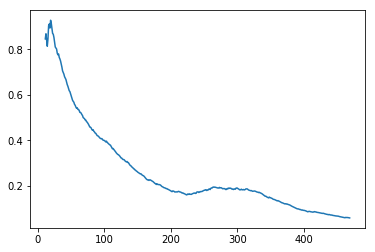

In [36]:
learn.unfreeze()

%time learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_entire_network_{size}')

## Current latest standing doesn't include the following fit'

In [37]:
size = 400
learn.set_data(get_data_from_dir(arch, size, get_aug_tfms(arch, size)))

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.148164   0.230839   0.927734  
    1      0.127294   0.20336    0.939453                  
    2      0.104216   0.198492   0.947266                  
    3      0.103909   0.217094   0.939453                  
    4      0.101241   0.192839   0.951172                   
    5      0.088277   0.194641   0.955078                   
    6      0.087299   0.189368   0.953125                   

CPU times: user 12min 32s, sys: 3min 12s, total: 15min 44s
Wall time: 7min 56s


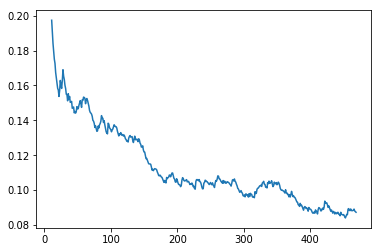

In [38]:
learn.freeze()
%time learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_last_layer_{size}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.204027   0.189887   0.942636  
    1      0.193871   0.245446   0.927734                  
    2      0.105435   0.133683   0.96875                   
    3      0.116878   0.442651   0.878906                   
    4      0.108122   0.148986   0.964844                  
    5      0.05875    0.14366    0.966797                   
    6      0.032177   0.129172   0.970703                   

CPU times: user 21min 55s, sys: 6min 1s, total: 27min 57s
Wall time: 20min 10s


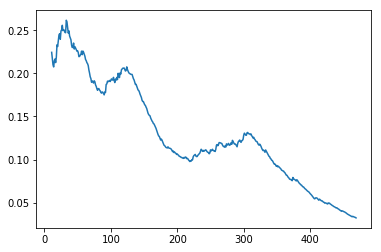

In [39]:
learn.unfreeze()

%time learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_entire_network_{size}')

# Check accuracy

## Validation set

In [ ]:
log_preds, y = learn.TTA()

In [ ]:
log_preds.shape

In [ ]:
log_preds[:,0,:]

In [ ]:
y.shape

In [ ]:
y[:5]

In [ ]:
probs = np.mean(np.exp(log_preds), 0)

In [ ]:
probs.shape

In [ ]:
probs[0,:]

In [ ]:
accuracy(probs, y)

## Test set

In [47]:
learn.data.classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [48]:
test_log_preds, test_y = learn.TTA(is_test=True)
test_probs = np.mean(np.exp(test_log_preds), 0)
print(accuracy(test_probs, test_y))

TypeError: torch.max received an invalid combination of arguments - got (numpy.ndarray, dim=int), but expected one of:
 * (torch.FloatTensor source)
 * (torch.FloatTensor source, torch.FloatTensor other)
      didn't match because some of the keywords were incorrect: dim
 * (torch.FloatTensor source, int dim)
 * (torch.FloatTensor source, int dim, bool keepdim)


In [49]:
print(test_probs.shape)
print(test_probs[:4])
print(test_probs[0, 0])

(794, 12)
[[0.00742 0.00013 0.00002 0.      0.9916  0.00064 0.00009 0.00001 0.      0.      0.      0.00009]
 [0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.99999 0.     ]
 [0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      1.      0.     ]
 [0.      0.      0.      0.      0.      0.      0.      1.      0.      0.      0.      0.     ]]
0.0074160127


In [50]:
class_indexes = np.argmax(test_probs, axis=1)

In [51]:
learn.data.classes[class_indexes[0]]

'Common wheat'

# Submit to kaggle (optional)

In [52]:
test_classes = [learn.data.classes[i] for i in class_indexes]
print(len(test_classes))
print(test_classes[:5])


794
['Common wheat', 'Small-flowered Cranesbill', 'Small-flowered Cranesbill', 'Maize', 'Small-flowered Cranesbill']


In [53]:
test_dl = learn.data.test_dl
test_filenames = test_dl.dataset.fnames
print(len(test_filenames))
print(test_filenames[:5])

794
['test/79e5ea8fa.png', 'test/3a909ead8.png', 'test/599691cd9.png', 'test/5ca2687a4.png', 'test/3dd52bd2a.png']


In [54]:
fileIds = np.array([f[5:] for f in test_filenames])
fileIds[:5]

array(['79e5ea8fa.png', '3a909ead8.png', '599691cd9.png', '5ca2687a4.png', '3dd52bd2a.png'], dtype='<U13')

In [55]:
submission = np.stack([fileIds,test_classes], axis=1)
submission[:5]

array([['79e5ea8fa.png', 'Common wheat'],
       ['3a909ead8.png', 'Small-flowered Cranesbill'],
       ['599691cd9.png', 'Small-flowered Cranesbill'],
       ['5ca2687a4.png', 'Maize'],
       ['3dd52bd2a.png', 'Small-flowered Cranesbill']], dtype='<U25')

In [56]:
!pwd

/home/paperspace/fastai/courses/dl1


In [57]:
now = datetime.datetime.now()
submission_file_name = f'plant-seed-submission-{str(now)}.csv'
# changed the decimal format from .5 to .10 and NO clip and moved into top 8% on kaggle (from 10%)
np.savetxt(submission_file_name, submission, fmt='%s,%s', header='file,species', comments='')

In [58]:
from IPython.display import FileLink
FileLink(submission_file_name)

/home/paperspace/fastai/courses/dl1/plant-seed-submission-2018-02-04 02:53:27.578705.csv

In [59]:
!date

Sun Feb  4 02:53:30 EST 2018
